In [5]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt # For low-level plotting
import seaborn as sns   #statistical visualizations

# little Aesthetic enhancements
sns.set(style="whitegrid", palette="muted")


In [6]:
#upload dataset
df = pd.read_csv('/content/drive/MyDrive/Practice projects/Sleep_health_and_lifestyle_dataset.csv')

In [7]:
# Basic preview
print(df.head())   # Shows first 5 rows
print(df.info())   # Data types and non-null counts

   Person ID Gender  Age  ... Heart Rate  Daily Steps  Sleep Disorder
0          1   Male   27  ...         77         4200             NaN
1          2   Male   28  ...         75        10000             NaN
2          3   Male   28  ...         75        10000             NaN
3          4   Male   28  ...         85         3000     Sleep Apnea
4          5   Male   28  ...         85         3000     Sleep Apnea

[5 rows x 13 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activi

In [8]:
#to check missing values
print(df.isna().sum())  # Missing value counts by column
print(df['Sleep Disorder'].value_counts())

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64
Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64


In [9]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Disorder')

In [10]:
print(df['Sleep Disorder'].value_counts())

Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


**Class Distribution and EDA Visual**

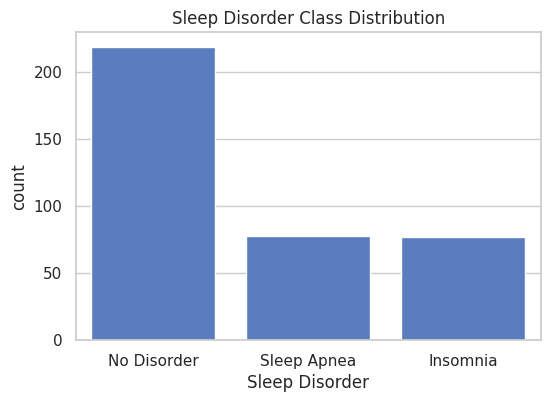

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='Sleep Disorder', data=df)
plt.title('Sleep Disorder Class Distribution')
plt.show()

**Numeric Feature Distributions**

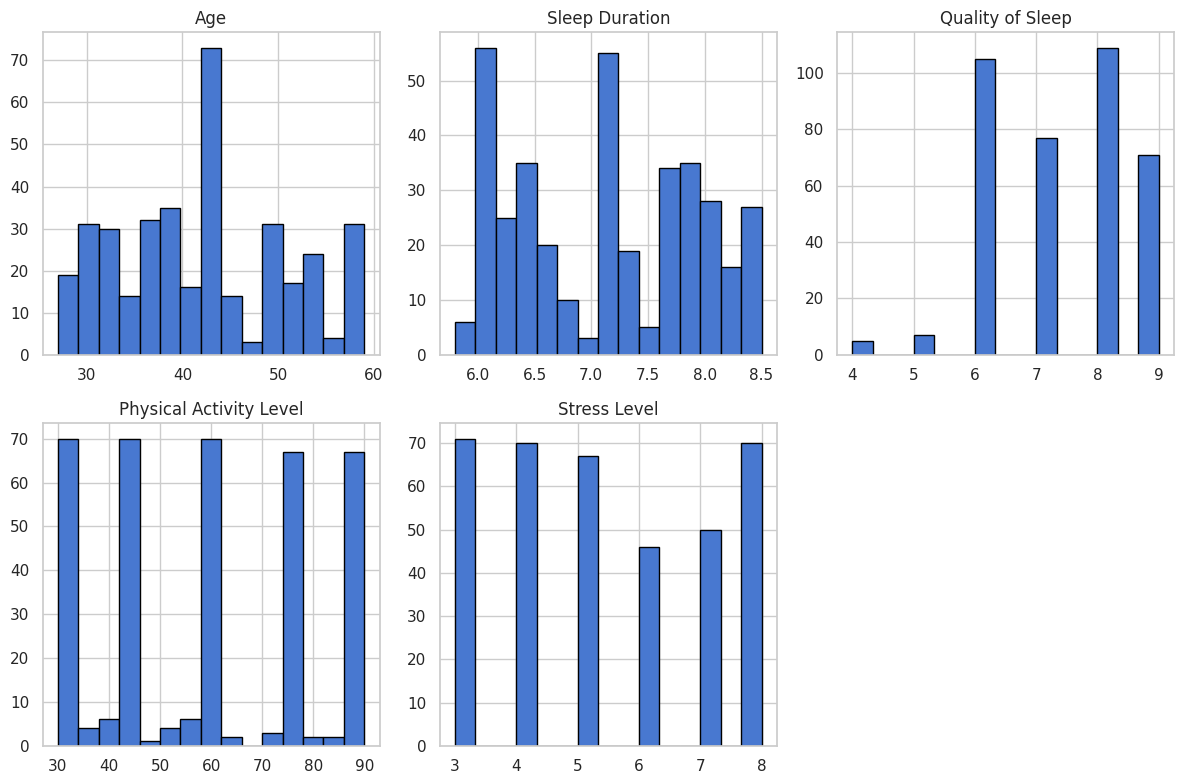

In [27]:
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep',
                'Physical Activity Level', 'Stress Level']

df[numeric_cols].hist(bins=15, figsize=(12,8), layout=(2,3),edgecolor='black')
plt.tight_layout()
plt.show()

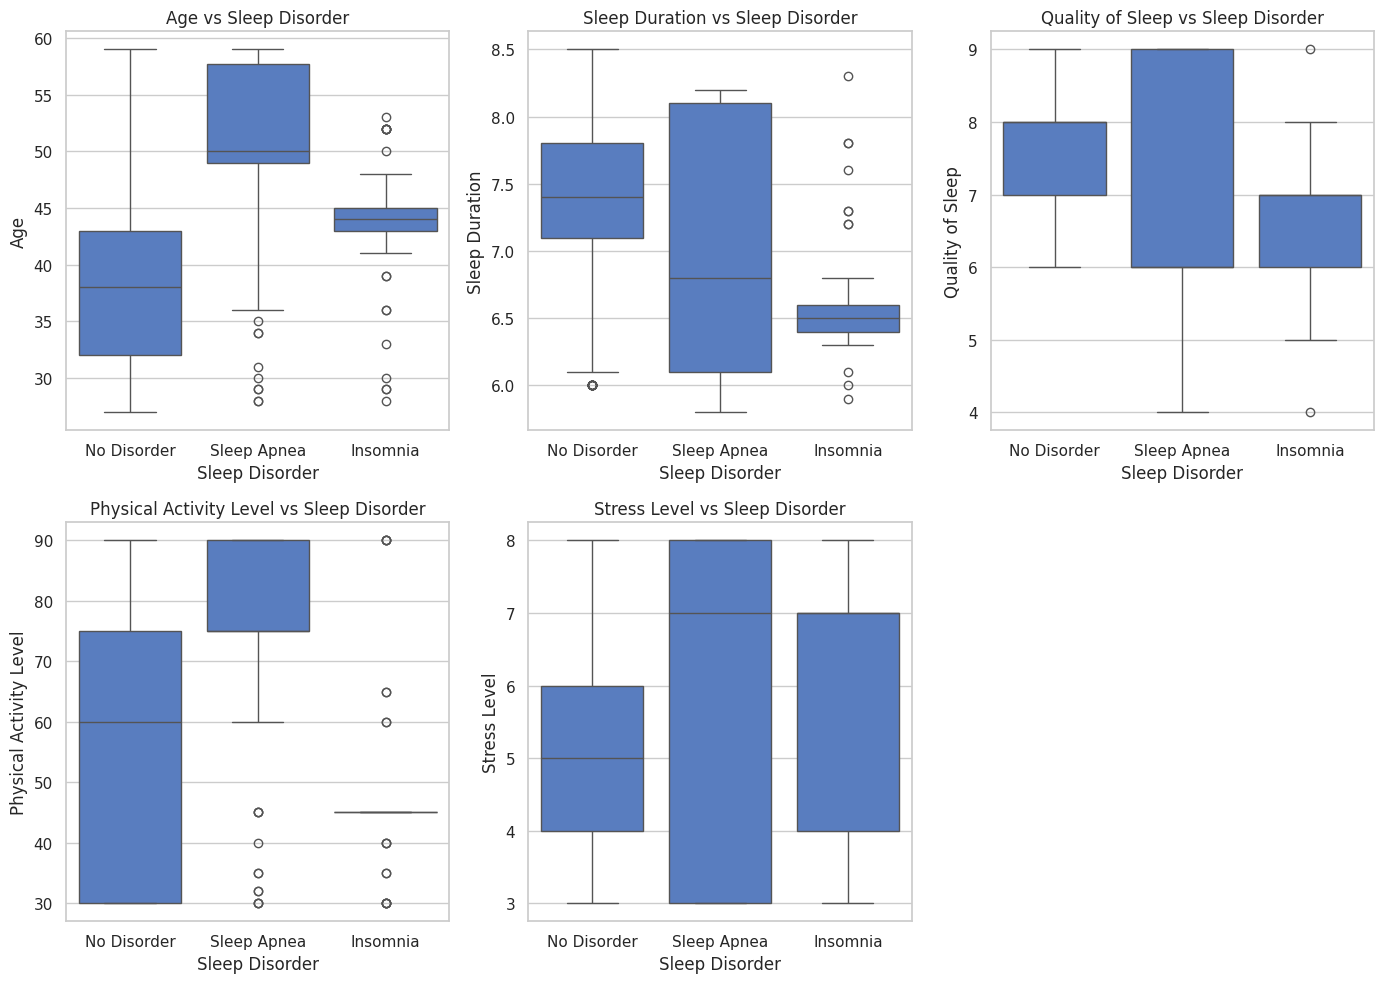

In [16]:
 #Numeric Features vs Sleep Disorder
 plt.figure(figsize=(14,10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Sleep Disorder', y=col, data=df)
    plt.title(f'{col} vs Sleep Disorder')
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

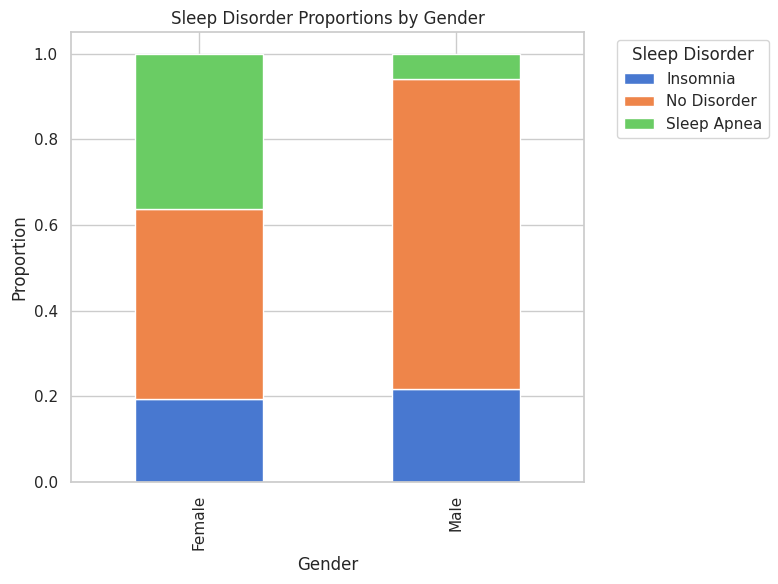

In [23]:
# Gender vs Sleep Disorder
plt.figure(figsize=(6,4))
pd.crosstab(df['Gender'], df['Sleep Disorder'], normalize='index').plot(
    kind='bar', stacked=True, figsize=(8,6))
plt.title('Sleep Disorder Proportions by Gender')
plt.ylabel('Proportion')
plt.legend(title='Sleep Disorder', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()



<Figure size 600x400 with 0 Axes>

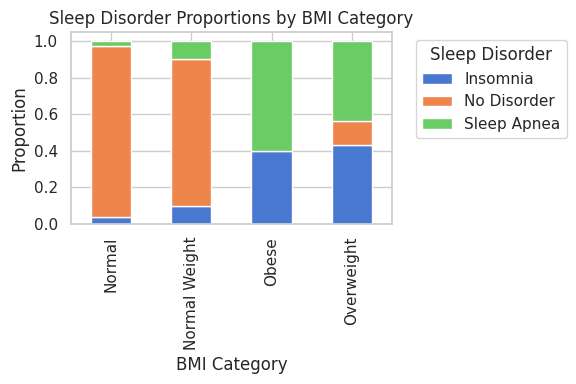

In [28]:
# BMI Category vs Sleep Disorder

plt.figure(figsize=(6,4))
pd.crosstab(df['BMI Category'], df['Sleep Disorder'], normalize='index').plot(
    kind='bar', stacked=True, figsize=(6,4))
plt.title('Sleep Disorder Proportions by BMI Category')
plt.ylabel('Proportion')
plt.legend(title='Sleep Disorder', bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

In [29]:
#adding new column to differentiate BP
df[['Systolic', 'Diastolic']] = (
    df['Blood Pressure']
      .str.split('/', expand=True)
      .astype(int)
)

**PrePreprocessing**

In [30]:
# Numeric features to scale or impute
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep',
                    'Physical Activity Level', 'Stress Level',
                    'Systolic', 'Diastolic']

# Categorical features to encode
categorical_features = ['Gender', 'BMI Category', 'Occupation']

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric transformer: impute missing as mean, scale
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical transformer: impute missing as most frequent, one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combined transformer for full dataset
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

**Train test and split**

In [34]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[numeric_features + categorical_features]
y = df['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train pipeline
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Sleep Duration',
                                                   'Quality of Sleep',
                                                   'Physical Activity Level',
                                                   'Stress Level', 'Systolic',
                                                   'Diastolic']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'BMI Category',
                                                   'Occupation'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [66]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    Insomnia       0.93      0.87      0.90        15
 No Disorder       1.00      1.00      1.00        44
 Sleep Apnea       0.88      0.94      0.91        16

    accuracy                           0.96        75
   macro avg       0.94      0.93      0.94        75
weighted avg       0.96      0.96      0.96        75

[[13  0  2]
 [ 0 44  0]
 [ 1  0 15]]


NameError: name 'clf_model' is not defined

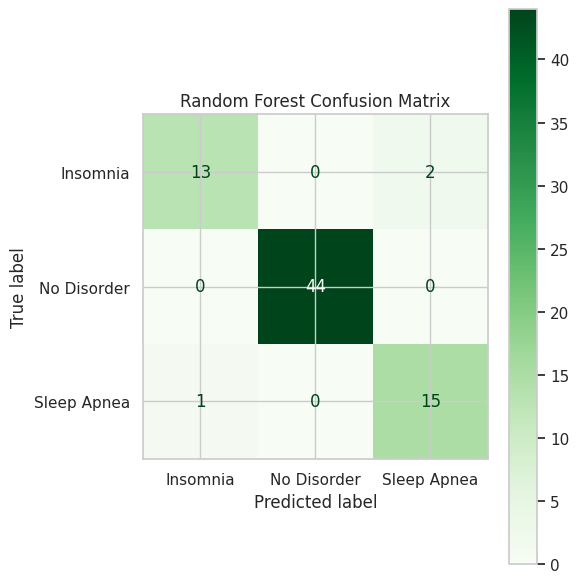

In [69]:
# Plot confusion matrix using your defined pipeline 'clf'
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    clf,               # use clf, your trained Random Forest pipeline
    X_test,
    y_test,
    display_labels=clf.classes_,  # class names from your pipeline
    cmap=plt.cm.Greens,
    ax=ax
)
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

In [43]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
# 7. Create full pipeline with Decision Tree
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',     # Gini impurity split measure :contentReference[oaicite:2]{index=2}
        max_depth=5,          # Limit tree depth to prevent overfitting
        random_state=42
    ))
])

In [46]:
# 8. Split data into train/test sets

X = df[numeric_features + categorical_features]
y = df['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Classification Report:
              precision    recall  f1-score   support

    Insomnia       0.93      0.87      0.90        15
 No Disorder       1.00      1.00      1.00        44
 Sleep Apnea       0.88      0.94      0.91        16

    accuracy                           0.96        75
   macro avg       0.94      0.93      0.94        75
weighted avg       0.96      0.96      0.96        75

Confusion Matrix:
[[13  0  2]
 [ 0 44  0]
 [ 1  0 15]]


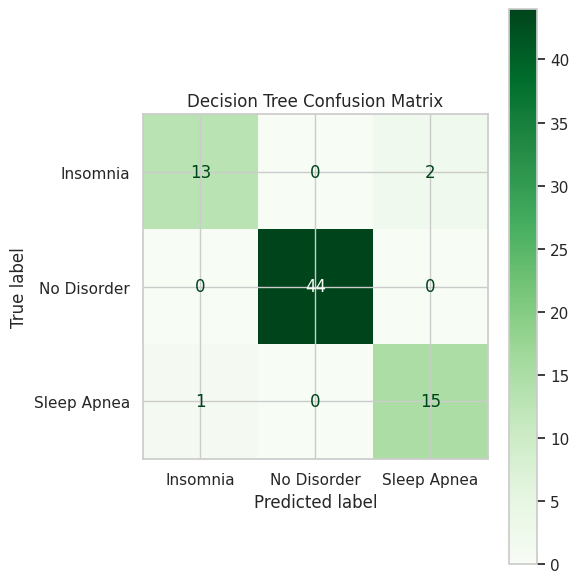

In [71]:
# 9. Train the model
clf.fit(X_train, y_train)


# 10. Evaluate model
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix using your trained Decision Tree pipeline (named 'clf')
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    clf,                  # your fitted Decision Tree pipeline
    X_test,
    y_test,
    display_labels=clf.classes_,  # ensures labels like "None", "Insomnia", "Sleep Apnea" are shown
    cmap=plt.cm.Greens,           # color theme
    ax=ax
)
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()


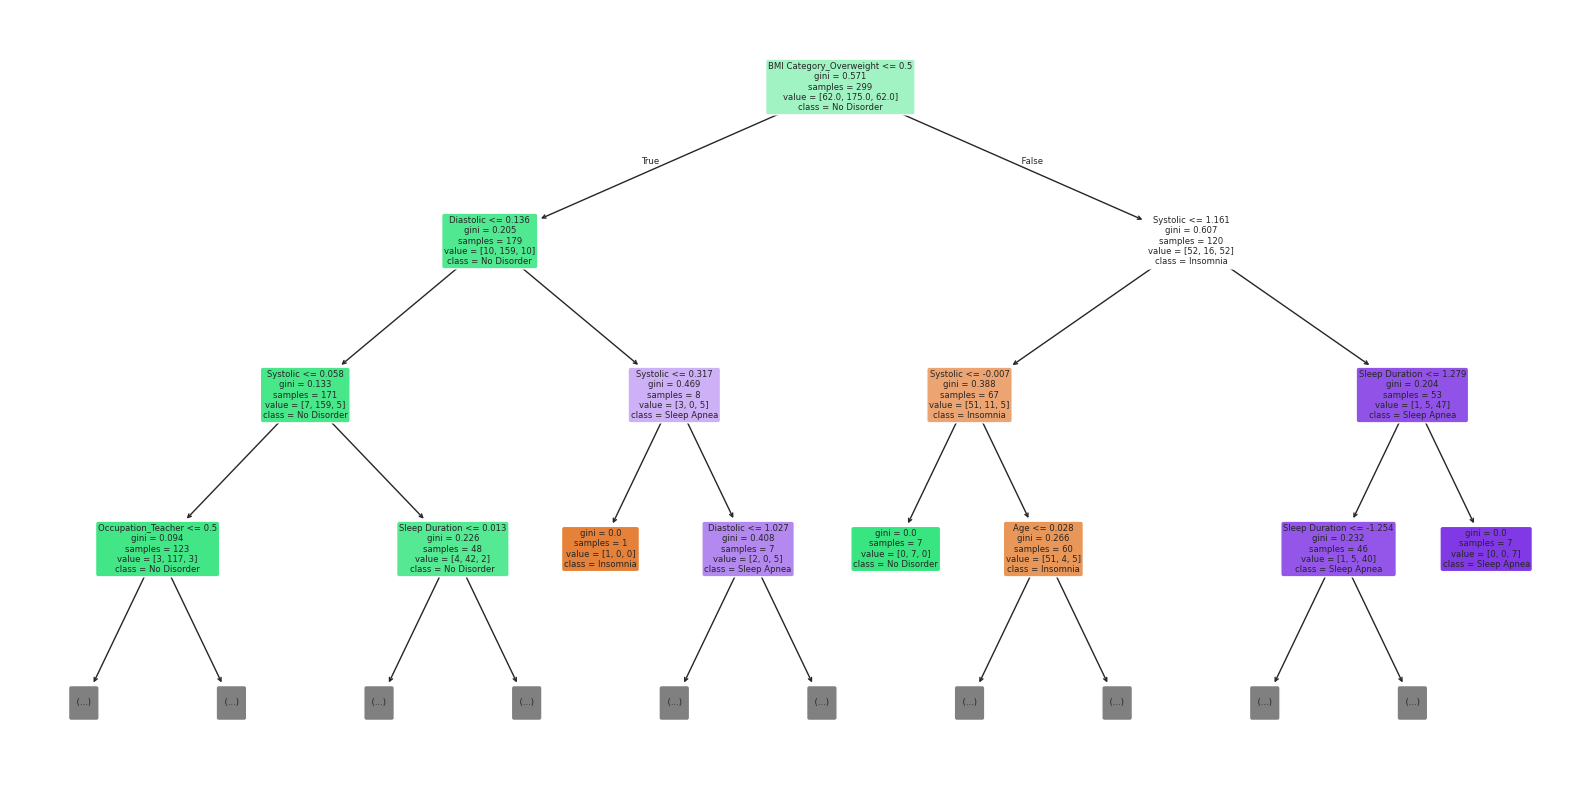

In [48]:
# 11. Visualize the decision tree
plt.figure(figsize=(20,10))
# Extract fitted DecisionTreeClassifier
tree = clf.named_steps['classifier']
# Provide feature names after transformation
feature_names = numeric_features + list(
    clf.named_steps['preprocessor']
       .named_transformers_['cat']
       .named_steps['onehot']
       .get_feature_names_out(categorical_features)
)
plot_tree(tree, feature_names=feature_names, class_names=tree.classes_,
          filled=True, rounded=True, max_depth=3)
plt.show()

**Hyperparameter Tuning**

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__min_impurity_decrease': [0.0, 0.01, 0.05]
}

grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'classifier__max_depth': 5, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}


In [51]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [3, 5, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f"CV best f1_macro: {grid.best_score_:.3f}")

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
CV best f1_macro: 0.872


In [52]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Insomnia       0.92      0.80      0.86        15
 No Disorder       1.00      1.00      1.00        44
 Sleep Apnea       0.83      0.94      0.88        16

    accuracy                           0.95        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.95      0.95      0.95        75

[[12  0  3]
 [ 0 44  0]
 [ 1  0 15]]


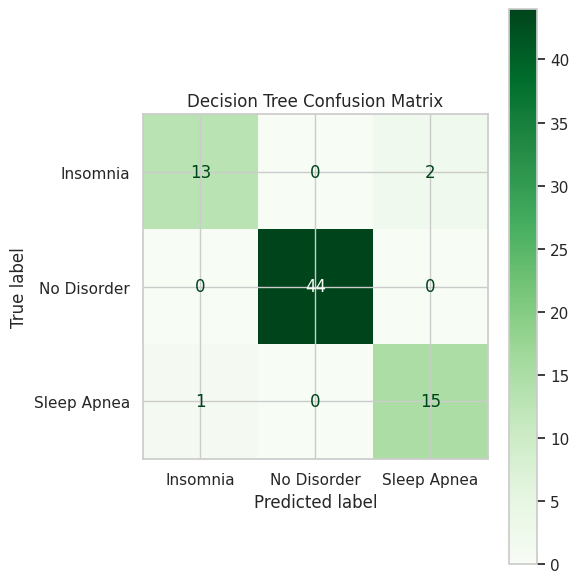

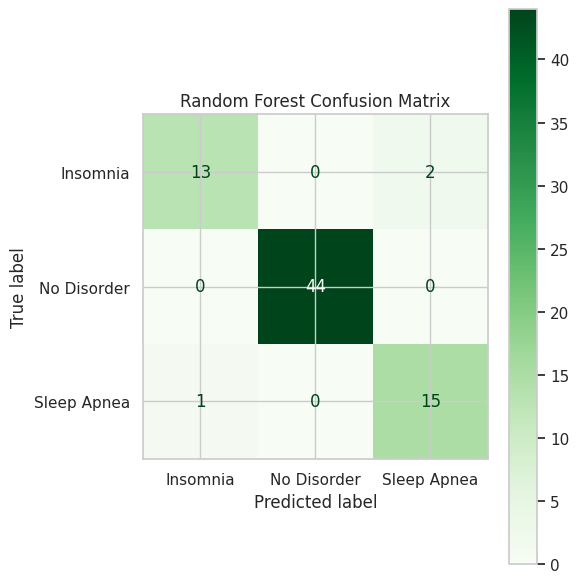

In [73]:
# Plot confusion matrix using your trained Decision Tree pipeline (named 'clf')
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    clf,                  # your fitted Decision Tree pipeline
    X_test,
    y_test,
    display_labels=clf.classes_,  # ensures labels like "None", "Insomnia", "Sleep Apnea" are shown
    cmap=plt.cm.Greens,           # color theme
    ax=ax
)
plt.title("Decision Tree Confusion Matrix")
plt.tight_layout()
plt.show()
# Plot confusion matrix using your defined pipeline 'clf'
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    clf,               # use clf, your trained Random Forest pipeline
    X_test,
    y_test,
    display_labels=clf.classes_,  # class names from your pipeline
    cmap=plt.cm.Greens,
    ax=ax
)
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()